# History Embedding

> Embed an environment into a more complex representation of state/observation-action histories

In [ ]:
#| default_exp Environments/HistoryEmbedding

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Examples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from MARLDynamics.Environments.SocialDilemma import SocialDilemma
from MARLDynamics.Environments.EcologicalPublicGood import EcologicalPublicGood

from MARLDynamics.Agents.StrategyActorCritic import stratAC
from MARLDynamics.Utils import FlowPlot as fp

In [ ]:
from MARLDynamics.Environments.HistoryEmbedding import HistoryEmbedded

In [ ]:
socdi = SocialDilemma(R=1.0, T=1.2, S=-0.5, P=0.0)
ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.1)

## Memory-1 Prisoner's Dilemma

With *history embedding*, we can wrap the standard normal form social dilemma envrionment into one, where the agents condition their action on the actions of the last rounds

In [ ]:
memo1pd = HistoryEmbedded(socdi, h=(1,1,1))

which has effectively a state set with the four elements 

In [ ]:
memo1pd.Sset

['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']

As you can see in the flow plots, this opens the possiblity for cooperation:

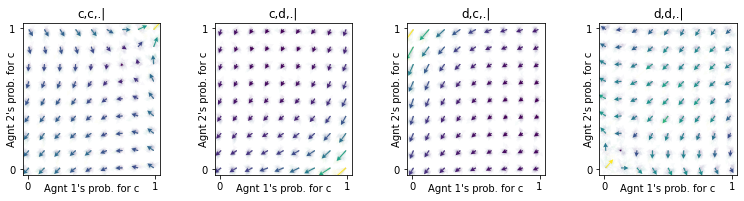

In [ ]:
mae1 = stratAC(env=memo1pd, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0,1,2,3], [0])
y = ([1], [0,1,2,3], [0])
ax = fp.plot_strategy_flow(mae1, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=mae1.env.Sset)


In contrast to the case where agents do not react to the actions of the past round. Here, the only strategy the agents learn is defection:

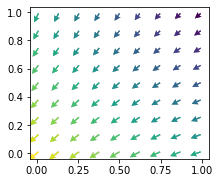

In [ ]:
mae0 = stratAC(env=socdi, learning_rates=0.1, discount_factors=0.9)
x = ([0], [0], [0])
y = ([1], [0], [0])
ax = fp.plot_strategy_flow(mae0, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32)

What is the effect of having longer action histories?

In [ ]:
hlen = 2
memoXpd = HistoryEmbedded(socdi, h=(1, hlen, hlen))
print( len(memoXpd.Sset) )

16


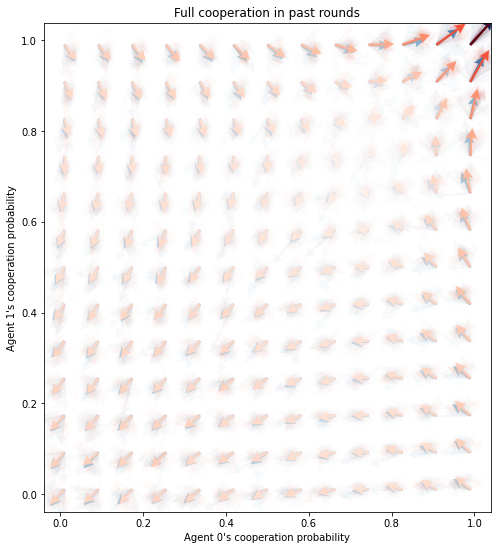

In [ ]:
maeX = stratAC(env=memoXpd, learning_rates=0.1, discount_factors=0.9)

fig, ax = plt.subplots(1,1, figsize=(8,9))
faps = np.linspace(0.01 ,0.99, 13)
x = ([0], [0], [0])
y = ([1], [0], [0])
fp.plot_strategy_flow(mae1, x, y, flowarrow_points=faps, NrRandom=32, cmap="Blues", axes=[ax])
fp.plot_strategy_flow(maeX, x, y, flowarrow_points=faps, NrRandom=32, cmap="Reds", axes=[ax]);
ax.set_xlabel("Agent 0's cooperation probability")
ax.set_ylabel("Agent 1's cooperation probability")
ax.set_title("Full cooperation in past rounds");

The longer action histories give additional force to mutual cooperation when the agents have cooperated in the past rounds and are close to cooperation. This suggests the hypothesis that longer action histories are beneficial for cooperation to be learned. However, more simulation would be needed to answer this question.

## Memory-1 Ecological Public Good

What is the effect of condition actions also on the past actions in the ecological public goods envrionment?

In [ ]:
ecopg1 = HistoryEmbedded(ecopg, h=(1,1,1))
ecopg1.Sset

['c,c,g|',
 'c,c,p|',
 'c,d,g|',
 'c,d,p|',
 'd,c,g|',
 'd,c,p|',
 'd,d,g|',
 'd,d,p|']

Visualizing the flow of learning in the prosperous state:

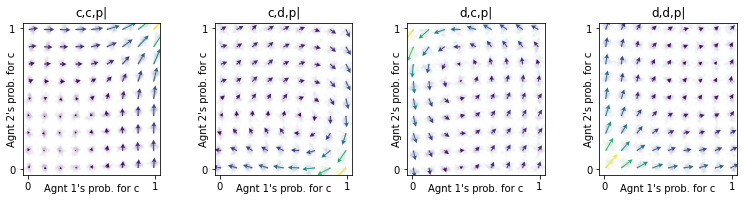

In [ ]:
mae1 = stratAC(env=ecopg1, learning_rates=0.1, discount_factors=0.9)
x = ([0], [1,3,5,7], [0])
y = ([1], [1,3,5,7], [0])
ax = fp.plot_strategy_flow(mae1, x, y, flowarrow_points=np.linspace(0.01 ,0.99, 9), NrRandom=32,
                           conds=np.array(mae1.env.Sset)[[1,3,5,7]])

This flow has similarites to the flow of the memory-1 Prisoner's Dilemma above, yet with more tendency toward cooperation. This is expected, since the ecological public good without memory-1 has also more tendency towards cooperation.

# API

In [ ]:
#| export
import numpy as np
import itertools as it
from fastcore.utils import *
from fastcore.test import *

from MARLDynamics.Environments.Base import ebase

## Histories

A history specification determines which realizations of the past the agents will conditions their actions on.  

A history specification `h` is an iterable of length 1+`N`. The first value indicates how many time steps of the state observation the agents will use to conditions their actions on. The remaining values indicate how many actions of each agent are used.

In [ ]:
#| export
def _get_all_histories(env, # An environment
                       h,  # A history specification
                       attr='Z'): #
    assert len(h) == env.N+1
    assert np.all(np.array(h)>=0)

    hiter = []  # history iterables 
    # go through the maximum history length
    for l in reversed(range(max(h))):
        # first: actions
        # go through all agents
        for n in range(env.N):
            # if 
            if l<h[1+n]:
                hiter.append(list(range(env.M)))
            else:
                hiter.append('.')

        # second: state
        # if specified hist-length is larger than current length
        if h[0] > l:
            # append hiter with range of states
            hiter.append(list(range(getattr(env, attr))))
        else:
            # if not: append dummy sign
            hiter.append('.')

    hists = list(it.product(*hiter)) 
    return hists

In [ ]:
show_doc(_get_all_histories)

---

[source](https://github.com/wbarfuss/MARLDynamics/blob/main/MARLDynamics/Environments/HistoryEmbedding.py#L16){target="_blank" style="float:right; font-size:smaller"}

### _get_all_histories

>      _get_all_histories (env, h, attr='Z')

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| env |  |  | An environment |
| h |  |  | A history specification |
| attr | str | Z |  |

The *default* history specification is `h=(1,0,0)`. Each agent observes information about the previous state, but none about the other agents.

In [ ]:
_get_all_histories(socdi, h=(1,0,0))

[('.', '.', 0)]

In [ ]:
_get_all_histories(ecopg, h=(1,0,0))

[('.', '.', 0), ('.', '.', 1)]

Each element of these lists is one *history*. The `'.'` indicates a dummy value for the non-observable actions. As you can see, here, the actions come before the state information - in contrast to the history specification `h`. You can think of time traveling from left to right in each history. First the agents choose their joint action, than they observe some state information, after which they choose another joint action. And so on, and so forth. 

For example, the often used *memory-one* social dilemmas can be obtained by

In [ ]:
_get_all_histories(socdi, h=(0,1,1))

[(0, 0, '.'), (0, 1, '.'), (1, 0, '.'), (1, 1, '.')]

Here, the information about the environment is discarded, indicated by the `'.'`.

But the action-history lengths need not be identical,

In [ ]:
_get_all_histories(socdi, h=(0,1,2))

[('.', 0, '.', 0, 0, '.'),
 ('.', 0, '.', 0, 1, '.'),
 ('.', 0, '.', 1, 0, '.'),
 ('.', 0, '.', 1, 1, '.'),
 ('.', 1, '.', 0, 0, '.'),
 ('.', 1, '.', 0, 1, '.'),
 ('.', 1, '.', 1, 0, '.'),
 ('.', 1, '.', 1, 1, '.')]

Here, each history contains six elements, since it spans two time steps, and each time step is represented by one element for each agent's action plus one element for the environment.

Of course, histories can be obtained for any environment.

In [ ]:
_get_all_histories(ecopg, h=(2,1,1))

[('.', '.', 0, 0, 0, 0),
 ('.', '.', 0, 0, 0, 1),
 ('.', '.', 0, 0, 1, 0),
 ('.', '.', 0, 0, 1, 1),
 ('.', '.', 0, 1, 0, 0),
 ('.', '.', 0, 1, 0, 1),
 ('.', '.', 0, 1, 1, 0),
 ('.', '.', 0, 1, 1, 1),
 ('.', '.', 1, 0, 0, 0),
 ('.', '.', 1, 0, 0, 1),
 ('.', '.', 1, 0, 1, 0),
 ('.', '.', 1, 0, 1, 1),
 ('.', '.', 1, 1, 0, 0),
 ('.', '.', 1, 1, 0, 1),
 ('.', '.', 1, 1, 1, 0),
 ('.', '.', 1, 1, 1, 1)]

With `_get_all_histories` we simply iterate through all state and action indicies. However, we are not checking whether a history is actually possible given the transition probabilities of the envrionment. 

In [ ]:
#| export
def _hist_contains_NotPossibleTrans(env, # An environment 
                                    hist:Iterable  # A history
                                   ) -> bool:  # History impossible?
    """
    Checks whether the history contains transitions which are not possible 
    with the environment's transition probabilities. 
    """
    assert len(hist)%(env.N+1) == 0
    maxh = int(len(hist) / (env.N+1)) # max history length

    contains = False
    # go through history from past to present
    s='.'
    for step in range(0, maxh):
        jA = hist[step*(env.N+1):step*(env.N+1)+env.N]
        s_ = hist[step*(env.N+1)+env.N]

        # construcing index for transition tensor
        ix = [s] if s!='.' else [slice(env.Z)]
        ix+= [jA[n] if jA[n]!='.' else slice(env.M) for n in range(env.N)]
        ix+= [s_] if s_!='.' else [slice(env.Z)]

        # check wheter there is possibility for current s,jA,s' tripple
        probability = np.sum(env.T[tuple(ix)])

        if probability==0:
            contains = True
            break
        else:
            # set new state s to s_
            s = s_
    return contains

In [ ]:
show_doc(_hist_contains_NotPossibleTrans)

---

[source](https://github.com/wbarfuss/MARLDynamics/blob/main/MARLDynamics/Environments/HistoryEmbedding.py#L47){target="_blank" style="float:right; font-size:smaller"}

### _hist_contains_NotPossibleTrans

>      _hist_contains_NotPossibleTrans (env, hist:Iterable)

Checks whether the history contains transitions which are not possible 
with the environment's transition probabilities.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| env |  | An environment |
| hist | typing.Iterable | A history |
| **Returns** | **bool** | **History impossible?** |

For example, in the prosperous state `1` of the ecological public good, when both agents choose the cooperative action `0`, there is no chance to leave the propserous state and enter the degraded state `0`.

In [ ]:
_hist_contains_NotPossibleTrans(ecopg, hist=('.', '.', 1, 0, 0, 0))

True

Thus, any history that contains this transition is not needed.

Yet, if only one agent chooses the defective action `0`, a transition to the degraded state becomes possible and corresponding histories cannot be discarded.

In [ ]:
_hist_contains_NotPossibleTrans(ecopg, hist=('.', '.', 1, 1, 0, 0))

False

In [ ]:
_hist_contains_NotPossibleTrans(ecopg, hist=('.', '.', 1, 0, 1, 0))

False

In [ ]:
#| export
def StateActHistsIx(env, h):
    """
    Returns all state-action histories (in indices) of `env`.

    `h` specifies the type of history. 
    `h` must be an iterable of length 1+N (where N = Nr. of Agents)
    The first element of `h` specifies the length of the state-history
    Subsequent elements specify the length of the respective action-history
    """
    
    # get all hists
    Hists = _get_all_histories(env, h)

    # Remove squences that are not possible
    PossibleHists = Hists.copy()
    for hist in Hists:
        if _hist_contains_NotPossibleTrans(env, hist):
            PossibleHists.remove(hist)
    return PossibleHists


For example, the *memory-one* social dilemmas is obtained by

In [ ]:
StateActHistsIx(socdi, h=(0,1,1))

[(0, 0, '.'), (0, 1, '.'), (1, 0, '.'), (1, 1, '.')]

which is identical to

In [ ]:
_get_all_histories(socdi, h=(0,1,1))

[(0, 0, '.'), (0, 1, '.'), (1, 0, '.'), (1, 1, '.')]

since all histories are actually possible in the environment.

However, in our ecological public good example, this is not the case:

In [ ]:
len(StateActHistsIx(ecopg, h=(2,1,1)))

15

In [ ]:
len(_get_all_histories(ecopg, h=(2,1,1)))

16

Depending on the environment, filtering out impossible histories can lead to a significant performance boost. 

In [ ]:
#| export
def hSset(env, # An environment 
          h):  # A history specificaiton
    '''
    String representation of the histories.
    '''
    hmax = max(h)
    
    hists = []
    for hist in StateActHistsIx(env, h):
        hrep = ''
        # go through all steps of the history
        for step in range(0, hmax):
            # first: all actions
            for i, n in enumerate(range(step*(env.N+1), step*(env.N+1)+env.N)):
                hrep += env.Aset[i][hist[n]] if hist[n]!="." else ''
                hrep += ','
            # second: append state
            hrep += env.Sset[hist[n+1]] if hist[n+1]!="." else ''
            hrep += '|'
        hists.append(hrep)
    
    return hists

For example,

In [ ]:
hSset(socdi, h=(1,1,1))

['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']

In [ ]:
hSset(ecopg, h=(2,1,1))

[',,g|c,c,g|',
 ',,g|c,c,p|',
 ',,g|c,d,g|',
 ',,g|c,d,p|',
 ',,g|d,c,g|',
 ',,g|d,c,p|',
 ',,g|d,d,g|',
 ',,g|d,d,p|',
 ',,p|c,c,p|',
 ',,p|c,d,g|',
 ',,p|c,d,p|',
 ',,p|d,c,g|',
 ',,p|d,c,p|',
 ',,p|d,d,g|',
 ',,p|d,d,p|']

## Transitions tensor

In [ ]:
#| export
def histSjA_TransitionTensor(env, h):
    """
    Returns Transition Tensor of `env` with state-action history specification `h`.
     
    `h` must be an iterable of length 1+N (where N = Nr. of Agents)
    The first element of `h` specifies the length of the state-history
    Subsequent elements specify the length of the respective action-history
    """
    hmax = max(h)

    def _transition_possible(hist, hist_):
        hi=hist[env.N+1:]; 
        hi_=hist_[:-(env.N+1)]
        possible = []
        for k in range((hmax-1)*(env.N+1)):
            poss = (hi[k]=='.') or (hi_[k]=='.') or (hi[k]==hi_[k])
            possible.append(poss)
        return np.all(possible)

    Hists = StateActHistsIx(env, h)

    Zh = len(Hists)
    Th_dims = list(env.T.shape)
    Th_dims[0] = Zh
    Th_dims[-1] = Zh
    Th = np.zeros(Th_dims)

    for i, hist in enumerate(Hists):
        for j, hist_ in enumerate(Hists):
            # Is the transition possible?
            possible = _transition_possible(hist, hist_)  
            # Get indices
            hix, ix = _transition_ix(env, h, i, hist, j, hist_)
        
            Th[hix] = possible*env.T[ix]

    return Th

def _transition_ix(env, h, i, hist, j, hist_):
    hmax = max(h)

    s = hist[-1]
    jA = hist_[(hmax-1)*(env.N+1):(hmax-1)*(env.N+1)+env.N]
    s_ = hist_[-1]

    # construcing index for transition tensor
    jAx = [jA[n] if jA[n]!='.' else slice(env.M) for n in range(env.N)]

    # for original tensor
    ix = [s] if s!='.' else [slice(env.Z)]
    ix += jAx
    ix+= [s_] if s_!='.' else [slice(env.Z)]

    # for history tensor
    hix = [i]+jAx+[j]

    return tuple(hix), tuple(ix)

For example,

In [ ]:
histSjA_TransitionTensor(socdi, h=(0,1,1)).shape

(4, 2, 2, 4)

In [ ]:
histSjA_TransitionTensor(ecopg, h=(2,1,1)).shape

(15, 2, 2, 15)

## Reward tensor

In [ ]:
#| export
def histSjA_RewardTensor(env, h):
    """
    Returns Reward Tensor of `env` with state-action history specification `h`.

    `h` must be an iterable of length 1+N (where N = Nr. of Agents)
    The first element of `h` specifies the length of the state-history
    Subsequent elements specify the length of the respective action-history
    """
    hmax=max(h)  # the maximum history length
    l = (env.N+1)*hmax  # length of a single history representation
                                    
    SAHists = StateActHistsIx(env, h)

    # dimension for history reward tensor
    Zh = len(SAHists)
    dims = list(env.R.shape)
    dims[1] = Zh
    dims[-1] = Zh

    Rh = np.zeros(dims)  # init reward tensor
    # go through all pairs of histories
    for i, hist in enumerate(SAHists):
        for j, hist_ in enumerate(SAHists):
            hix, ix = _transition_ix(env, h, i, hist, j, hist_)
            hix = tuple([slice(env.N)]+list(hix))
            ix = tuple([slice(env.N)]+list(ix))
            Rh[hix] = env.R[ix]
    
    return Rh

For example,

In [ ]:
histSjA_RewardTensor(socdi, h=(1,1,1)).shape

(2, 4, 2, 2, 4)

In [ ]:
histSjA_RewardTensor(ecopg, h=(1,1,1)).shape

(2, 8, 2, 2, 8)

## Partial observation and environmental uncertainty

Note: These elements are useful for enviroments with state uncertainty or likewise, partial observability. Such are not yet available in this respository.

In [ ]:
#| export
def ObsActHistsIx(env, h):
    """
    Returns all obs-action histories of `env`.
    
    `h` specifies the type of history.
    `h` must be an iterable of length 1+N (where N = Nr. of Agents)
    The first element of `h` specifies the length of the obs-history
    Subsequent elements specify the length of the respective action-history
        
    Note: Here only partial observability regarding the envrionmental state
    applies. Additional partial observability regarding action is treated 
    seperatly.
    """
    
    SAhists = StateActHistsIx(env, h=h)
    OAhists = _get_all_histories(env, h=h, attr='Q')

    hmax=max(h)  # the maximum history length
    l = (env.N+1)*hmax  # length of a single history representation

    # Remove squences that are not possible to observe
    # for all agents
    # check all ohist elements
    PossibleOAHists = OAhists.copy()
    for oahist in OAhists:
        # whether they are observable by agent i
        observable = np.zeros(env.N)
        # go through all shist elements
        for sahist in SAhists:
            # check wheter action profile fits
            sAs = [list(sahist[k:k+env.N]) for k in range(0, l, env.N+1)]
            oAs = [list(oahist[k:k+env.N]) for k in range(0, l, env.N+1)]
            if sAs == oAs:
                # and then check whether oahist can be observed from sahist
                observable += np.prod([env.O[:, sahist[k], oahist[k]]
                                    for k in range((env.N+1)*(hmax-h[0])+env.N,
                                                   l, env.N+1)], axis=0)
        # if oahist can't be observed by any agent
        if np.allclose(observable, 0.0):
            # remove ohist from ObsHists
            PossibleOAHists.remove(oahist)
    return PossibleOAHists

In [ ]:
ObsActHistsIx(socdi, h=(1,1,1))

[(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 0)]

In [ ]:
#| export
def hOset(env, h):
    hmax = max(h)
    
    all_hists = []
    for agent in range(env.N):
        hists = []
        for hist in ObsActHistsIx(env, h):
            hrep = ''
            # go through all steps of the history
            for step in range(0, hmax):
                # first: all actions
                for i, n in enumerate(range(step*(env.N+1), step*(env.N+1)+env.N)):
                    hrep += env.Aset[i][hist[n]] if hist[n]!="." else ''
                    hrep += ','
                # second: append observation
                hrep += env.Oset[agent][hist[n+1]] if hist[n+1]!="." else ''
                hrep += '|'
            hists.append(hrep)
        all_hists.append(hists)
    
    return all_hists

In [ ]:
hOset(socdi, h=(1,1,1))

[['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|'],
 ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']]

In [ ]:
#| export
def histSjA_ObservationTensor(env, h):
    """
    Returns Observation Tensor of `env` with state-action history `h`[iterable]
    """
    hmax=max(h)  # the maximum history length
    l = (env.N+1)*hmax  # length of a single history representation

    SAhists = StateActHistsIx(env, h=h)
    OAhists = ObsActHistsIx(env, h=h)

    Qh = len(OAhists)
    Zh = len(SAhists)
    Oh = np.zeros((env.N, Zh, Qh))

    # go through each sh oh pair
    for i, sahist in enumerate(SAhists):
        for j, oahist in enumerate(OAhists):
            # check wheter action profile fits
            sAs = [list(sahist[k:k+env.N]) for k in range(0, l, env.N+1)]
            oAs = [list(oahist[k:k+env.N]) for k in range(0, l, env.N+1)]
            if sAs == oAs:
                Oh[:, i, j] = np.prod([env.O[:, sahist[k], oahist[k]]
                                for k in range((env.N+1)*(hmax-h[0])+env.N,
                                                l, env.N+1)], axis=0)
    return Oh           


In [ ]:
histSjA_ObservationTensor(socdi, h=(1,1,1))

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

## Environment wrapper

In [ ]:
#| export
class HistoryEmbedded(ebase):
    """
    Abstract Environment wrapper to embed a given environment into a larger
    history space
    
    `h` must be an iterable of length 1+N (where N=Nr. of Agents)
    The first element of `history` specifies the length of the state-history.
    Subsequent elements specify the length of the respective action-history
    """
    
    def __init__(self, 
                 env, # An environment
                 h):  # History specification
        self.baseenv = env
        self.h = h
        
        self.N = self.baseenv.N
        self.M = self.baseenv.M
        self.Z = len(self.states())
        self.Q = len(self.observations())
        
        super().__init__()

    def actions(self):
        return self.baseenv.Aset

    def states(self):
        return hSset(self.baseenv, self.h)
    
    def observations(self):
        return hOset(self.baseenv, self.h)
    
    def TransitionTensor(self):
        return histSjA_TransitionTensor(self.baseenv, self.h)
    
    def RewardTensor(self):
        return histSjA_RewardTensor(self.baseenv, self.h)
    
    def ObservationTensor(self):
        return histSjA_ObservationTensor(self.baseenv, self.h)
    
    def id(self):
        id = f"{self.__class__.__name__}{self.baseenv.id()}_h{self.h}"
        return id

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()